In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import os
from IPython import display
import time
import shutil
import logging
import datetime
import json
from numpy import array

In [3]:
import numpy as np
import pandas as pd

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
from sklearn import preprocessing
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
import sklearn.preprocessing as preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

In [6]:
from PIL import Image

In [7]:
from keras.models import Model # basic class for specifying and training a neural network
from keras.layers import Input, Convolution2D, MaxPooling2D,ZeroPadding2D, Dense, Dropout, Activation, Flatten
from keras.utils import np_utils # utilities for one-hot encoding of ground truth values
from keras.layers import BatchNormalization
from keras.utils import layer_utils
from keras import layers
from keras.layers import AveragePooling2D
from keras.layers import GlobalAveragePooling2D
from keras.models import model_from_json

Using TensorFlow backend.


In [8]:
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.utils import np_utils
from keras.utils import to_categorical
from keras import backend as K
K.set_image_dim_ordering('tf')

In [9]:
logging.basicConfig(filename='EnsemblePretrained.log',level=logging.DEBUG)
ts = datetime.datetime.now()
logging.info("******************************************************************")
logging.info("Execution started at - "+ts.strftime("%Y-%m-%d %H:%M:%S"))

<span style="color:#337AFF;font-size:18px;font-weight:bold;">Custom functions</span>

In [10]:
def fun_SetWorkingDirectoryPath(directoryPath):
    os.chdir(directoryPath)

In [11]:
def fun_DeleteWorkingDirectory(working_dir_path):
    if os.path.exists(working_dir_path):
        shutil.rmtree(working_dir_path)
        logging.info("Deleted Working Directory")
        print("Deleted Working Directory Successfully !")
    else:
        logging.error("Directory Doesn't Exist")
        print("Directory Doesn't Exist !")
    print("")

In [12]:
def fun_CreateWorkingDirectories(directory):
    if not os.path.exists(directory):
        os.makedirs(directory)
        logging.info(directory + "  -  Created !")
        print(directory + "  -  Created !")
    print("")

In [13]:
def fun_GetFilesList(directoryPath):
    files_list = []
    for root, directories, filenames in os.walk(directoryPath):
        for filename in filenames:
            iterImage = filename.upper()
            if(iterImage.endswith(".JPG") or iterImage.endswith(".JPEG") or iterImage.endswith(".PNG")):
                files_list.append(os.path.join(root,filename))
    
    return(files_list)

In [14]:
def fun_ConvertImagesToArray(readFile, imageFilesList):
    imageFileArray = []
    filesReadCount = 0
    #for tempImages in imageFilesList:
    logging.debug("Reading {0} images :".format(readFile))
    print("Reading {0} images :".format(readFile))
    for tempImages in log_progress(imageFilesList, every=1):
        iterImage = tempImages.upper()
        if(iterImage.endswith(".JPG") or iterImage.endswith(".JPEG") or iterImage.endswith(".PNG")):
            tempArray = np.array(Image.open(tempImages))
            if (len(tempArray.shape))==2:
                tempShape = tempArray.shape
                tempArray = tempArray.reshape(tempShape[0], tempShape[1], 1)
            imageFileArray.append(tempArray)
            filesReadCount = filesReadCount + 1
    print("")
        
    return(np.asarray(imageFileArray))

In [15]:
def fun_GetLabelsFromFileNames(entire_images_list):
    Y_Master = []
    for image_name in entire_images_list:
        try:
            temp = image_name.split("/")
            Y_Master.append(int(temp[len(temp)-2][1]))
        except:
            continue
    return(Y_Master)

In [16]:
def fun_ConvertImages(readFile, imageFilesList, resizeHeight=None, resizeWidth=None, isGrayScaledConversion=None):
    imageFileArray = []
    filesReadCount = 0
    logging.debug("Converting {0} to the desired format :".format(readFile))
    print("Converting {0} to the desired format :".format(readFile))
    for tempImages in log_progress(imageFilesList, every=1):
        iterImage = tempImages.upper()
        if(iterImage.endswith(".JPG") or iterImage.endswith(".JPEG") or iterImage.endswith(".PNG")):
            image=Image.open(tempImages)
            
            if (resizeHeight is not None and resizeWidth is not None):
                image = image.resize((resizeHeight, resizeWidth))

            if (isGrayScaledConversion):
                image=image.convert('L')

            temp = tempImages.replace("Complete Dataset", "Working Dir")
            image.save(temp)
            imageFileArray.append(temp)
            filesReadCount = filesReadCount + 1
            
    return (readFile, imageFileArray)

In [17]:
def fun_Delete_And_Create_Working_Dir(working_dir_path):
    fun_DeleteWorkingDirectory(working_dir_path)
    for i in range(0,10):
        fun_CreateWorkingDirectories(working_dir_path + "imgs/train/c" + str(i))

In [18]:
def log_progress(sequence, every=None, size=None, name='Items'):
    from ipywidgets import IntProgress, HTML, VBox
    from IPython.display import display

    is_iterator = False
    if size is None:
        try:
            size = len(sequence)
        except TypeError:
            is_iterator = True
    if size is not None:
        if every is None:
            if size <= 200:
                every = 1
            else:
                every = int(size / 200)     # every 0.5%
    else:
        assert every is not None, 'sequence is iterator, set every'

    if is_iterator:
        progress = IntProgress(min=0, max=1, value=1)
        progress.bar_style = 'info'
    else:
        progress = IntProgress(min=0, max=size, value=0)
    label = HTML()
    box = VBox(children=[label, progress])
    display(box)

    index = 0
    try:
        for index, record in enumerate(sequence, 1):
            if index == 1 or index % every == 0:
                if is_iterator:
                    label.value = '{name}: {index} / ?'.format(
                        name=name,
                        index=index
                    )
                else:
                    progress.value = index
                    label.value = u'{name}: {index} / {size}'.format(
                        name=name,
                        index=index,
                        size=size
                    )
            yield record
    except:
        progress.bar_style = 'danger'
        raise
    else:
        progress.bar_style = 'success'
        progress.value = index
        label.value = "{name}: {index}".format(
            name=name,
            index=str(index or '?')
        )

In [19]:
def fun_oneHotEncode(labels):
    values = array(labels)
    onehot_encoder = OneHotEncoder(sparse=False)
    values=values.reshape(len(values), 1)
    onehot_encoded = to_categorical(values)
    return onehot_encoded

In [20]:
def save_model(working_dir_path, model, index, cross=''):
    print(model)
    json_string = model.to_json()
    if not os.path.isdir(working_dir_path + '/cache'):
        os.mkdir(working_dir_path + '/cache')
    json_name = 'architecture' + str(index) + cross + '.json'
    weight_name = 'model_weights' + str(index) + cross + '.h5'
    open(os.path.join(working_dir_path + '/cache', json_name), 'w').write(json_string)
    print(working_dir_path + '/cache')
    model.save_weights(os.path.join(working_dir_path + '/cache', weight_name), overwrite=True)

In [21]:
def read_model(working_dir_path, index, cross=''):
    json_name = 'architecture' + str(index) + cross + '.json'
    weight_name = 'model_weights' + str(index) + cross + '.h5'
    model = model_from_json(open(os.path.join(working_dir_path + '/cache', json_name)).read())
    model.load_weights(os.path.join(working_dir_path + '/cache', weight_name),by_name=True)
    return model

In [22]:
def read_model_history(save_model_path, name):
    history_json_name = 'modelHistory' + name + '.json'
    if os.path.exists(save_model_path + 'cache/' + history_json_name):
        history_model = model_from_json(open(os.path.join(save_model_path + 'cache', history_json_name)).read())
        return history_model

In [23]:
def fun_AlexNet_model():
    model = Sequential()
    
    # 1st Convolutional Layer
    model.add(Conv2D(filters=96, input_shape=(224,224,3), kernel_size=(11,11),\
                     strides=(4,4), padding='valid'))
    model.add(Activation('relu'))
    # Pooling 
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'))
    # Batch Normalisation before passing it to the next layer
    model.add(BatchNormalization())
    
    # 2nd Convolutional Layer
    model.add(Conv2D(filters=256, kernel_size=(11,11), strides=(1,1), padding='valid'))
    model.add(Activation('relu'))
    # Pooling
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'))
    # Batch Normalisation
    model.add(BatchNormalization())
    
    # 3rd Convolutional Layer
    model.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='valid'))
    model.add(Activation('relu'))
    # Batch Normalisation
    model.add(BatchNormalization())
    
    # 4th Convolutional Layer
    model.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='valid'))
    model.add(Activation('relu'))
    # Batch Normalisation
    model.add(BatchNormalization())
    
    # 5th Convolutional Layer
    model.add(Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='valid'))
    model.add(Activation('relu'))
    # Pooling
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'))
    # Batch Normalisation
    model.add(BatchNormalization())

    # Passing it to a dense layer
    model.add(Flatten())
    # 1st Dense Layer
    model.add(Dense(4096, input_shape=(224*224*3,)))
    model.add(Activation('relu'))
    # Add Dropout to prevent overfitting
    model.add(Dropout(0.4))
    # Batch Normalisation
    model.add(BatchNormalization())
    
    # 2nd Dense Layer
    model.add(Dense(4096))
    model.add(Activation('relu'))
    # Add Dropout
    model.add(Dropout(0.4))
    # Batch Normalisation
    model.add(BatchNormalization())

    # 3rd Dense Layer
    model.add(Dense(1000))
    model.add(Activation('relu'))
    # Add Dropout
    model.add(Dropout(0.4))
    # Batch Normalisation
    model.add(BatchNormalization())

    # Output Layer
    #model.add(Dense(10))
    #model.add(Activation('softmax'))

    return model

In [24]:
def evaluate(prediction, true_label):
    pred_indices = np.argmax(prediction, 1)
    true_indices = np.argmax(true_label, 1)

    return np.mean(pred_indices == true_indices)

In [25]:
def unweighted_average_ensemble(predictions):

   # print("Predictions " ,np.asarray(predictions))
   # print("Mean Predictions " ,np.mean(np.asarray(predictions), 0))

    return np.mean(np.asarray(predictions), 0)

In [26]:
def majority_voting_ensemble(predictions):

    one_hot_predictions = []
    
    for prediction in predictions:
      #  print("type before encode ", type(prediction))
      #  print("before encoding", prediction.round())
        #one_hot_predictions.append(fun_oneHotEncode(np.argmax(prediction, axis = 1)))
        #one_hot_predictions.append((np.argmax(prediction, axis = 1)).round())
        predargmax = np.argmax(prediction, axis = 1)
        #predargmax[0]=9
       # print("after arg max ", predargmax)
        encoded = np_utils.to_categorical(predargmax)
        #print("after encode ", encoded)
        one_hot_predictions.append(encoded)
       # one_hot_predictions.append(np_utils.to_categorical(np.argmax(prediction, axis = 1)))
        
    #convpreds = np.asarray(one_hot_predictions)
    #print("$$$$$$$$$$$$$", type(one_hot_predictions))
    #print(one_hot_predictions)

    return np.sum(one_hot_predictions, 0)

<span style="color:#337AFF;font-size:18px;font-weight:bold;">Loading input Data</span>

In [27]:
source_dir_path = "/mnt/home/kumar.manjushree_gmail/Capstone/imgs/train/"

In [28]:
working_dir_path = "/mnt/home/kumar.manjushree_gmail/Capstone/WorkingDir/"

In [29]:
source_dir_path

'/mnt/home/kumar.manjushree_gmail/Capstone/imgs/train/'

In [30]:
## Cleanse working directory
fun_Delete_And_Create_Working_Dir(working_dir_path)

Deleted Working Directory Successfully !

/mnt/home/kumar.manjushree_gmail/Capstone/WorkingDir/imgs/train/c0  -  Created !

/mnt/home/kumar.manjushree_gmail/Capstone/WorkingDir/imgs/train/c1  -  Created !

/mnt/home/kumar.manjushree_gmail/Capstone/WorkingDir/imgs/train/c2  -  Created !

/mnt/home/kumar.manjushree_gmail/Capstone/WorkingDir/imgs/train/c3  -  Created !

/mnt/home/kumar.manjushree_gmail/Capstone/WorkingDir/imgs/train/c4  -  Created !

/mnt/home/kumar.manjushree_gmail/Capstone/WorkingDir/imgs/train/c5  -  Created !

/mnt/home/kumar.manjushree_gmail/Capstone/WorkingDir/imgs/train/c6  -  Created !

/mnt/home/kumar.manjushree_gmail/Capstone/WorkingDir/imgs/train/c7  -  Created !

/mnt/home/kumar.manjushree_gmail/Capstone/WorkingDir/imgs/train/c8  -  Created !

/mnt/home/kumar.manjushree_gmail/Capstone/WorkingDir/imgs/train/c9  -  Created !



In [31]:
## List of images
entire_images_list = fun_GetFilesList(source_dir_path)
print(source_dir_path)
logging.debug("(entire_images_list) :".format(len(entire_images_list)))
print("(entire_images_list) :", len(entire_images_list))

/mnt/home/kumar.manjushree_gmail/Capstone/imgs/train/
(entire_images_list) : 22424


In [32]:
## List of labels
entire_labels_list = fun_GetLabelsFromFileNames(entire_images_list)
logging.debug("(entire_labels_list) :".format(len(entire_labels_list)))
print("(entire_labels_list) :", len(entire_labels_list))

(entire_labels_list) : 22424


In [33]:
## Data frame of training set    
filePath_Labels_List_df = pd.DataFrame(
                                        {
                                            'Files_Path': entire_images_list,
                                            'Labels'    : entire_labels_list
                                        }
)

In [34]:
## Stratified sample
train_test_filePath_Labels_List_df = filePath_Labels_List_df.sample(n=3000, random_state=10)

In [35]:
num_classes=10

In [36]:
## Shuffling images in sample
for i in range(num_classes):
    logging.debug("(Label, Number of Rows) : ({0}, {1})".format(i, len(
        train_test_filePath_Labels_List_df[train_test_filePath_Labels_List_df["Labels"]==i])))
    print("(Label, Number of Rows) : ({0}, {1})".format(i, len(
        train_test_filePath_Labels_List_df[train_test_filePath_Labels_List_df["Labels"]==i])))
    print("")
    train_test_filePath_Labels_List_df_shuffled = train_test_filePath_Labels_List_df.reindex(
        np.random.permutation(train_test_filePath_Labels_List_df.index))


(Label, Number of Rows) : (0, 350)

(Label, Number of Rows) : (1, 297)

(Label, Number of Rows) : (2, 314)

(Label, Number of Rows) : (3, 310)

(Label, Number of Rows) : (4, 297)

(Label, Number of Rows) : (5, 335)

(Label, Number of Rows) : (6, 277)

(Label, Number of Rows) : (7, 266)

(Label, Number of Rows) : (8, 246)

(Label, Number of Rows) : (9, 308)



In [37]:
train_test_filePath_Labels_List_df_shuffled.head(10)

,Files_Path,Labels
15284,/mnt/home/kumar.manjushree_gmail/Capstone/imgs...,3
4438,/mnt/home/kumar.manjushree_gmail/Capstone/imgs...,7
5549,/mnt/home/kumar.manjushree_gmail/Capstone/imgs...,7
14373,/mnt/home/kumar.manjushree_gmail/Capstone/imgs...,3
15376,/mnt/home/kumar.manjushree_gmail/Capstone/imgs...,2
6526,/mnt/home/kumar.manjushree_gmail/Capstone/imgs...,6
17165,/mnt/home/kumar.manjushree_gmail/Capstone/imgs...,2
15350,/mnt/home/kumar.manjushree_gmail/Capstone/imgs...,3
12548,/mnt/home/kumar.manjushree_gmail/Capstone/imgs...,4
9907,/mnt/home/kumar.manjushree_gmail/Capstone/imgs...,5


<span style="color:#337AFF;font-size:18px;font-weight:bold;">Splitting and preprocessing</span>

In [38]:
## Split into train and test
X_train, X_test, Y_train, Y_test = (train_test_split(
                                                train_test_filePath_Labels_List_df_shuffled["Files_Path"], 
                                                train_test_filePath_Labels_List_df_shuffled["Labels"], 
                                                test_size = 0.3,
                                                random_state = 10
                                            )
                                   )
logging.debug("(X_train, Y_train) : ({0}, {1})".format(len(X_train), len(Y_train)))
print("(X_train, Y_train) : ({0}, {1})", len(X_train), len(Y_train))
logging.debug("(X_test, Y_test)   : ({0}, {1})".format(len(X_test), len(Y_test)))
print("(X_test, Y_test)   : ({0}, {1})", len(X_test), len(Y_test))
print("")

(X_train, Y_train) : ({0}, {1}) 2100 2100
(X_test, Y_test)   : ({0}, {1}) 900 900



In [39]:
X_train.shape

(2100,)

In [40]:
Y_train.shape

(2100,)

In [41]:
Y_test.shape

(900,)

In [42]:
## Resize train images
    
(readFile, imageFileArray) = fun_ConvertImages(
                            readFile="X_train",
                            imageFilesList=X_train, 
                            resizeHeight=224, 
                            resizeWidth=224, 
                            isGrayScaledConversion=False
                    )
    

Converting X_train to the desired format :


A Jupyter Widget

In [43]:
## Convert train images to Array
X_train = fun_ConvertImagesToArray(
                   readFile,
                   imageFileArray
              )
    
X_train = X_train.astype('float32') 
#Y_train = Y_train.astype('float32') 

Reading X_train images :


A Jupyter Widget

In [44]:
# Normalise data to [0, 1] range
X_train /= np.max(X_train)
#Y_train /= np.max(Y_train)
    
logging.debug("(X_train.shape, Y_train.shape) : ({0}, {1})".format(X_train.shape, Y_train.shape))
print("(X_train.shape, Y_train.shape) : ({0}, {1})".format(X_train.shape, Y_train.shape))

(X_train.shape, Y_train.shape) : ((2100, 224, 224, 3), (2100,))


In [45]:
# One-hot encode the train labels
Y_train = fun_oneHotEncode(Y_train)

In [46]:
## Resize test images
(readFile, imageFileArray) = fun_ConvertImages(
                        readFile="X_test",
                        imageFilesList=X_test, 
                        resizeHeight=224, 
                        resizeWidth=224, 
                        isGrayScaledConversion=False
                )

Converting X_test to the desired format :


A Jupyter Widget

In [47]:
## Convert test images to Array
X_test  = fun_ConvertImagesToArray(
                       readFile,
                       imageFileArray
                  )
        
X_test = X_test.astype('float32') 
#Y_test = Y_test.astype('float32')

Reading X_test images :


A Jupyter Widget

In [48]:
# Normalise data to [0, 1] range
X_test /= np.max(X_test)
#Y_test /= np.max(Y_test)
logging.debug("(X_test.shape, Y_test.shape) : ({0}, {1})".format(X_test.shape, Y_test.shape))
print("(X_test.shape, Y_test.shape) : ({0}, {1})".format(X_test.shape, Y_test.shape))    

(X_test.shape, Y_test.shape) : ((900, 224, 224, 3), (900,))


In [49]:
# One-hot encode the test labels
Y_test = fun_oneHotEncode(Y_test)

In [50]:
## Prepare input
img_rows, img_cols, img_channel = 224, 224, 3
img_shape=(img_rows, img_cols, img_channel)

<span style="color:#337AFF;font-size:18px;font-weight:bold;">Defining models</span>

In [51]:
from keras import optimizers
from keras.applications.vgg16 import VGG16
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping
from keras.applications.resnet50 import ResNet50,preprocess_input
from keras.applications.mobilenet import MobileNet

In [52]:
loss="categorical_crossentropy"
optimizer="adam"
metrics="accuracy"
batch_size = 64
num_epochs = 20
validation_split=0.2
estimators=[]

<span style="color:#337AFF;font-size:14 px;font-weight:bold;">VGG 16</span>

In [53]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(img_rows, img_cols, img_channel))
add_model = Sequential()
add_model.add(Flatten(input_shape=base_model.output_shape[1:]))
add_model.add(Dense(10, activation='softmax'))
vgg16model = Model(inputs=base_model.input, outputs=add_model(base_model.output))
estimators.append(('vgg16', vgg16model))

In [54]:
vgg16model.compile(loss=loss, optimizer=optimizers.SGD(lr=1e-4, momentum=0.9),
              metrics=['accuracy'])
earlyStop=EarlyStopping(monitor='val_acc', min_delta=0.001, patience=5, \
                          verbose=1, mode='auto')
callback = [earlyStop]

In [55]:
vgg16model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

<span style="color:#337AFF;font-size:14px;font-weight:bold;">AlexNet</span>

In [56]:
base_model = fun_AlexNet_model()

In [57]:
x = base_model.output
#x = Flatten()(x)
predictions = Dense(num_classes, activation='softmax', name='fc10')(x)

In [58]:
alexnetmodel = Model(input=base_model.input, output=predictions)
estimators.append(('alexnet', alexnetmodel))

In [59]:
## Compile and fit model
alexnetmodel.compile(loss=loss, optimizer=optimizer, metrics=[metrics])
earlyStop=EarlyStopping(monitor='val_acc', min_delta=0.001, patience=5, \
                          verbose=1, mode='auto')
callback = [earlyStop]

In [60]:
alexnetmodel.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1_input (InputLayer)  (None, 224, 224, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 54, 54, 96)        34944     
_________________________________________________________________
activation_1 (Activation)    (None, 54, 54, 96)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 27, 27, 96)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 27, 27, 96)        384       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 17, 17, 256)       2973952   
_________________________________________________________________
activation_2 (Activation)    (None, 17, 17, 256)       0         
__________

<span style="color:#337AFF;font-size:14px;font-weight:bold;">ResNet50</span>

In [61]:
base_model = ResNet50(include_top=False, weights='imagenet', input_tensor=None, input_shape=img_shape)

In [62]:
x = base_model.output
x = Flatten()(x)
predictions = Dense(num_classes, activation='softmax', name='fc1000')(x)

In [63]:
resnetmodel = Model(input=base_model.input, output=predictions)
estimators.append(('resnet', resnetmodel))

In [78]:
## Compile and fit model
resnetmodel.compile(loss=loss, optimizer=optimizer, metrics=[metrics])
earlyStop=EarlyStopping(monitor='val_loss', min_delta=0.001, patience=5, \
                          verbose=1, mode='auto')
callback = [earlyStop]

In [79]:
resnetmodel.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

<span style="color:#337AFF;font-size:14px;font-weight:bold;">MobileNet</span>

In [66]:
base_model = MobileNet(input_shape=None, alpha=1.0, depth_multiplier=1, dropout=1e-3,\
                       include_top=True, weights='imagenet', input_tensor=None, pooling=None)

In [67]:
x = base_model.output
#x = Flatten()(x)
predictions = Dense(num_classes, activation='softmax', name='fc10')(x)

In [68]:
mobilenetmodel = Model(input=base_model.input, output=predictions)
estimators.append(('mobilenet', mobilenetmodel))

In [69]:
## Compile and fit model
mobilenetmodel.compile(loss=loss, optimizer=optimizer, metrics=[metrics])
earlyStop=EarlyStopping(monitor='val_acc', min_delta=0.001, patience=10, \
                          verbose=1, mode='auto')
callback = [earlyStop]

In [70]:
mobilenetmodel.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 226, 226, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (Activation)      (None, 112, 112, 32)      0         
_________________________________________________________________
conv_pad_1 (ZeroPadding2D)   (None, 114, 114, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
__________

<span style="color:#337AFF;font-size:18px;font-weight:bold;">Training Models</span>

In [71]:
vgg16_fixed_model = vgg16model.fit(X_train,Y_train, batch_size=batch_size, nb_epoch=num_epochs,\
                        verbose=1, validation_data=(X_test,Y_test), callbacks=callback)

In [72]:
save_model("/mnt/home/kumar.manjushree_gmail/Capstone/", vgg16model, 0, cross='vgg16')

In [73]:
print(vgg16_fixed_model.history.keys())
# summarize history for accuracy
plt.plot(vgg16_fixed_model.history['acc'])
plt.plot(vgg16_fixed_model.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(vgg16_fixed_model.history['loss'])
plt.plot(vgg16_fixed_model.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [74]:
alexnetmodel_fixed_model = alexnetmodel.fit(X_train,Y_train, batch_size=batch_size, nb_epoch=num_epochs,\
                       verbose=1, validation_data=(X_test,Y_test), callbacks=callback)

In [75]:
save_model("/mnt/home/kumar.manjushree_gmail/Capstone/", alexnetmodel, 0, cross='alexnet')

In [76]:
print(alexnetmodel_fixed_model.history.keys())
# summarize history for accuracy
plt.plot(alexnetmodel_fixed_model.history['acc'])
plt.plot(alexnetmodel_fixed_model.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(alexnetmodel_fixed_model.history['loss'])
plt.plot(alexnetmodel_fixed_model.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [80]:
loss="categorical_crossentropy"
optimizer="adam"
metrics="accuracy"
batch_size = 64
num_epochs = 50
validation_split=0.2
estimators=[]

In [81]:
resnetmodel_fixed_model = resnetmodel.fit(X_train,Y_train, batch_size=batch_size, nb_epoch=num_epochs,\
                        verbose=1, validation_data=(X_test,Y_test), callbacks=callback)

Train on 2100 samples, validate on 900 samples
Epoch 1/50
2100/2100 [==============================] - 1464s 697ms/step - loss: 2.6556 - acc: 0.1676 - val_loss: 8.0283 - val_acc: 0.1033
Epoch 2/50
2100/2100 [==============================] - 1455s 693ms/step - loss: 2.4950 - acc: 0.2014 - val_loss: 14.4526 - val_acc: 0.1033
Epoch 3/50
2100/2100 [==============================] - 1454s 692ms/step - loss: 2.6096 - acc: 0.1362 - val_loss: 12.9021 - val_acc: 0.1122
Epoch 4/50
2100/2100 [==============================] - 1461s 696ms/step - loss: 2.4879 - acc: 0.1562 - val_loss: 8.2899 - val_acc: 0.0822
Epoch 5/50
2100/2100 [==============================] - 1461s 696ms/step - loss: 2.3995 - acc: 0.1800 - val_loss: 2.3472 - val_acc: 0.1544
Epoch 6/50
2100/2100 [==============================] - 1453s 692ms/step - loss: 2.2890 - acc: 0.1990 - val_loss: 7.4878 - val_acc: 0.1122
Epoch 7/50
2100/2100 [==============================] - 1462s 696ms/step - loss: 2.2560 - acc: 0.2457 - val_loss: 14.

In [82]:
save_model("/mnt/home/kumar.manjushree_gmail/Capstone/", resnetmodel, 1, cross='resnet')

/mnt/home/kumar.manjushree_gmail/Capstone//cache


dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


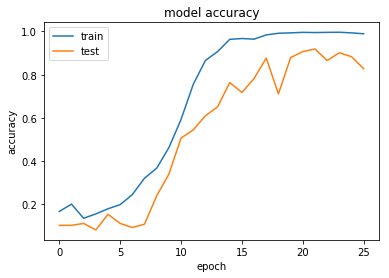

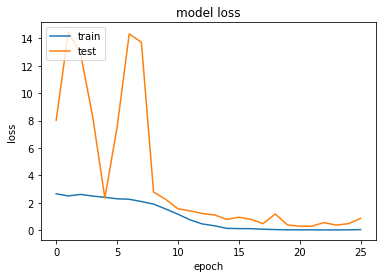

In [83]:
print(resnetmodel_fixed_model.history.keys())
# summarize history for accuracy
plt.plot(resnetmodel_fixed_model.history['acc'])
plt.plot(resnetmodel_fixed_model.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(resnetmodel_fixed_model.history['loss'])
plt.plot(resnetmodel_fixed_model.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [84]:
mobilenetmodel_fixed_model = mobilenetmodel.fit(X_train,Y_train, batch_size=batch_size, nb_epoch=num_epochs,\
                        verbose=1, validation_data=(X_test,Y_test), callbacks=callback)

Train on 2100 samples, validate on 900 samples
Epoch 1/50
2100/2100 [==============================] - 613s 292ms/step - loss: 2.2656 - acc: 0.2881 - val_loss: 2.2365 - val_acc: 0.4367
Epoch 2/50
2100/2100 [==============================] - 608s 289ms/step - loss: 2.2037 - acc: 0.5733 - val_loss: 2.1990 - val_acc: 0.5078
Epoch 3/50
2100/2100 [==============================] - 591s 281ms/step - loss: 2.1475 - acc: 0.6095 - val_loss: 2.2375 - val_acc: 0.2867
Epoch 4/50
2100/2100 [==============================] - 597s 285ms/step - loss: 2.0927 - acc: 0.6471 - val_loss: 2.2160 - val_acc: 0.3067
Epoch 5/50
2100/2100 [==============================] - 601s 286ms/step - loss: 2.0431 - acc: 0.6533 - val_loss: 2.1257 - val_acc: 0.4211
Epoch 6/50
2100/2100 [==============================] - 594s 283ms/step - loss: 1.9932 - acc: 0.6510 - val_loss: 2.0839 - val_acc: 0.4978
Epoch 7/50
2100/2100 [==============================] - 600s 286ms/step - loss: 1.9531 - acc: 0.6452 - val_loss: 2.0415 - val

In [85]:
save_model("/mnt/home/kumar.manjushree_gmail/Capstone/", mobilenetmodel, 0, cross='mobilenet')

/mnt/home/kumar.manjushree_gmail/Capstone//cache


In [ ]:
print(mobilenetmodel_fixed_model.history.keys())
# summarize history for accuracy
plt.plot(mobilenetmodel_fixed_model.history['acc'])
plt.plot(mobilenetmodel_fixed_model.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(mobilenetmodel_fixed_model.history['loss'])
plt.plot(mobilenetmodel_fixed_model.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

<span style="color:#337AFF;font-size:18px;font-weight:bold;">Plotting accuracies and losses</span>

In [ ]:
#fixed_model=read_model_history(save_model_path,"VGG19Pretrained")

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
#print(fixed_model.history.keys())
# summarize history for accuracy
plt.plot(vgg16_fixed_model.history['val_acc'])
plt.plot(alexnetmodel_fixed_model.history['val_acc'])
plt.plot(resnetmodel_fixed_model.history['val_acc'])
plt.plot(mobilenetmodel_fixed_model.history['val_acc'])
plt.title('model accuracies')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['vgg16', 'alexnet', 'resnet', 'mobilenet'], loc='upper left')
plt.show()

In [ ]:
# summarize history for loss
plt.plot(vgg16_fixed_model.history['val_loss'])
plt.plot(alexnetmodel_fixed_model.history['val_loss'])
plt.plot(resnetmodel_fixed_model.history['val_loss'])
plt.plot(mobilenetmodel_fixed_model.history['val_loss'])
plt.title('model losses')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['vgg16', 'alexnet', 'resnet', 'mobilenet'], loc='upper left')
plt.show()

<span style="color:#337AFF;font-size:18px;font-weight:bold;">Confusion Matrices and Predictions</span>

In [ ]:
import seaborn as sns
from sklearn.metrics import accuracy_score

In [ ]:
predictions = []
model_name = "VGG16Predictions"
extension = '.npy'
prediction_path = './predictions/' + model_name + extension

In [ ]:
## Evaluate model
#scores=model.evaluate(X_test, Y_test, verbose=1)
#print("Loss ", scores[0], "Accuracy ", scores[1])


# Look at confusion matrix 
from sklearn.metrics import confusion_matrix

In [ ]:
# Predict the values from the validation dataset
Y_pred = vgg16model.predict(X_test)
np.save(prediction_path, Y_pred)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(Y_test,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
ax = sns.heatmap(confusion_mtx)

In [ ]:
predictions.append(Y_pred)

In [ ]:
# Predict
test_acc = round(accuracy_score(Y_test, Y_pred.round())*100)
print("Test accuracy:", test_acc)

resultList = []
classType = []
for i in range(len(X_test)):
    preds = Y_pred[i]
    print("Predictions", i, preds.round())
    print("Labels", i, Y_test[i])
    if (np.argmax(preds.round()) == np.argmax(Y_test[i])):
        resultList.append("right")
        classType.append(np.argmax(Y_test[i]))
    else:
        resultList.append("wrong")
        classType.append(np.argmax(Y_test[i]))

In [ ]:
class_df = pd.DataFrame(
                            {
                                'Class': classType,
                                'Labels': Y_test[:,0],
                                'Predictions'    : Y_pred[:,0],
                                'Result': resultList
                            }
    )

In [ ]:
class_df.head(5)

In [ ]:
groupedClassResult = pd.DataFrame({'count' : class_df.groupby( [ "Class", "Result"] ).size()}).reset_index()
groupedClassResult.shape
groupedClass = pd.DataFrame({'count' : class_df.groupby( [ "Class"] ).size()}).reset_index()
groupedClass.shape
merged_inner = pd.merge(left=groupedClass,right=groupedClassResult, left_on='Class', right_on='Class')
merged_inner.columns = ['Class', 'TotalCount', 'Result', 'ResultCount']

In [ ]:
merged_df = merged_inner.pivot_table('ResultCount', ['Class', 'TotalCount'], 'Result').fillna(0)
merged_df['RightPrediction%'] = (merged_df['right']/(merged_df['right']+merged_df['wrong']))*100
merged_df

In [ ]:
model_name = "alexnetPredictions"
extension = '.npy'
prediction_path = './predictions/' + model_name + extension

In [ ]:

# Predict the values from the validation dataset
Y_pred = alexnetmodel.predict(X_test)
np.save(prediction_path, Y_pred)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(Y_test,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
ax = sns.heatmap(confusion_mtx)

In [ ]:
predictions.append(Y_pred)

In [ ]:
# Predict
test_acc = round(accuracy_score(Y_test, Y_pred.round())*100)
print("Test accuracy:", test_acc)

resultList = []
classType = []
for i in range(len(X_test)):
    preds = Y_pred[i]
    print("Predictions", i, preds.round())
    print("Labels", i, Y_test[i])
    if (np.argmax(preds.round()) == np.argmax(Y_test[i])):
        resultList.append("right")
        classType.append(np.argmax(Y_test[i]))
    else:
        resultList.append("wrong")
        classType.append(np.argmax(Y_test[i]))

In [ ]:
class_df = pd.DataFrame(
                            {
                                'Class': classType,
                                'Labels': Y_test[:,0],
                                'Predictions'    : Y_pred[:,0],
                                'Result': resultList
                            }
    )

In [ ]:
class_df.head(5)

In [ ]:
groupedClassResult = pd.DataFrame({'count' : class_df.groupby( [ "Class", "Result"] ).size()}).reset_index()
groupedClassResult.shape
groupedClass = pd.DataFrame({'count' : class_df.groupby( [ "Class"] ).size()}).reset_index()
groupedClass.shape
merged_inner = pd.merge(left=groupedClass,right=groupedClassResult, left_on='Class', right_on='Class')
merged_inner.columns = ['Class', 'TotalCount', 'Result', 'ResultCount']

In [ ]:
merged_df = merged_inner.pivot_table('ResultCount', ['Class', 'TotalCount'], 'Result').fillna(0)
merged_df['RightPrediction%'] = (merged_df['right']/(merged_df['right']+merged_df['wrong']))*100
merged_df

In [ ]:
model_name = "ResnetPredictions"
extension = '.npy'
prediction_path = './predictions/' + model_name + extension

In [ ]:

# Predict the values from the validation dataset
Y_pred = resnetmodel.predict(X_test)
np.save(prediction_path, Y_pred)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(Y_test,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
ax = sns.heatmap(confusion_mtx)

In [ ]:
predictions.append(Y_pred)

In [ ]:
# Predict
test_acc = round(accuracy_score(Y_test, Y_pred.round())*100)
print("Test accuracy:", test_acc)

resultList = []
classType = []
for i in range(len(X_test)):
    preds = Y_pred[i]
    print("Predictions", i, preds.round())
    print("Labels", i, Y_test[i])
    if (np.argmax(preds.round()) == np.argmax(Y_test[i])):
        resultList.append("right")
        classType.append(np.argmax(Y_test[i]))
    else:
        resultList.append("wrong")
        classType.append(np.argmax(Y_test[i]))

In [ ]:
class_df = pd.DataFrame(
                            {
                                'Class': classType,
                                'Labels': Y_test[:,0],
                                'Predictions'    : Y_pred[:,0],
                                'Result': resultList
                            }
    )

In [ ]:
class_df.head(5)

In [ ]:
groupedClassResult = pd.DataFrame({'count' : class_df.groupby( [ "Class", "Result"] ).size()}).reset_index()
groupedClassResult.shape
groupedClass = pd.DataFrame({'count' : class_df.groupby( [ "Class"] ).size()}).reset_index()
groupedClass.shape
merged_inner = pd.merge(left=groupedClass,right=groupedClassResult, left_on='Class', right_on='Class')
merged_inner.columns = ['Class', 'TotalCount', 'Result', 'ResultCount']

In [ ]:
merged_df = merged_inner.pivot_table('ResultCount', ['Class', 'TotalCount'], 'Result').fillna(0)
merged_df['RightPrediction%'] = (merged_df['right']/(merged_df['right']+merged_df['wrong']))*100
merged_df

In [ ]:
model_name = "mobilenetpredictions"
extension = '.npy'
prediction_path = './predictions/' + model_name + extension

In [ ]:

# Predict the values from the validation dataset
Y_pred = mobilenetmodel.predict(X_test)
np.save(prediction_path, Y_pred)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(Y_test,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
ax = sns.heatmap(confusion_mtx)

In [ ]:
predictions.append(Y_pred)

In [ ]:
# Predict
test_acc = round(accuracy_score(Y_test, Y_pred.round())*100)
print("Test accuracy:", test_acc)

resultList = []
classType = []
for i in range(len(X_test)):
    preds = Y_pred[i]
    print("Predictions", i, preds.round())
    print("Labels", i, Y_test[i])
    if (np.argmax(preds.round()) == np.argmax(Y_test[i])):
        resultList.append("right")
        classType.append(np.argmax(Y_test[i]))
    else:
        resultList.append("wrong")
        classType.append(np.argmax(Y_test[i]))

In [ ]:
class_df = pd.DataFrame(
                            {
                                'Class': classType,
                                'Labels': Y_test[:,0],
                                'Predictions'    : Y_pred[:,0],
                                'Result': resultList
                            }
    )

In [ ]:
class_df.head(5)

In [ ]:
groupedClassResult = pd.DataFrame({'count' : class_df.groupby( [ "Class", "Result"] ).size()}).reset_index()
groupedClassResult.shape
groupedClass = pd.DataFrame({'count' : class_df.groupby( [ "Class"] ).size()}).reset_index()
groupedClass.shape
merged_inner = pd.merge(left=groupedClass,right=groupedClassResult, left_on='Class', right_on='Class')
merged_inner.columns = ['Class', 'TotalCount', 'Result', 'ResultCount']

In [ ]:
merged_df = merged_inner.pivot_table('ResultCount', ['Class', 'TotalCount'], 'Result').fillna(0)
merged_df['RightPrediction%'] = (merged_df['right']/(merged_df['right']+merged_df['wrong']))*100
merged_df

<span style="color:#337AFF;font-size:18px;font-weight:bold;">Ensembling</span>

In [ ]:
ensemble_accuracy = evaluate(unweighted_average_ensemble(predictions), Y_test)
print('Accuracy by Unweighted Average Ensemble: ', ensemble_accuracy * 100, '%')

In [ ]:
ensemble_accuracy = evaluate(majority_voting_ensemble(predictions), Y_test)
print('Accuracy by Majority Voting Ensemble: ', ensemble_accuracy * 100, '%')

In [ ]:
#vgg16classifier = KerasClassifier(vgg16model)
#alexnetclassifier = KerasClassifier(alexnetmodel)
#resnetclassifier = KerasClassifier(resnetmodel)
#mobilenetclassifier = KerasClassifier(mobilenetmodel)

In [ ]:
#eclf = EnsembleVoteClassifier(clfs=[vgg16classifier, alexnetclassifier, resnetclassifier, mobilenetclassifier], weights=[1,1,1,1])

In [ ]:
#eclf.fit(X_train, Y_train[:,0])

In [ ]:
# generate a model from the layers above
#model = Model(inputs=inputs, outputs=predictions)
#model.compile(optimizer='adam',
#              loss=loss,
#              metrics=['accuracy'])

In [ ]:
#model.summary()

In [ ]:
#print(results.mean())

<span style="color:#337AFF;font-size:18px;font-weight:bold;">Predicting class of images using ensemble model</span>

In [ ]:
## List of images to predict
input_images_list = fun_GetFilesList("/mnt/home/kumar.manjushree_gmail/Capstone/predict")
logging.debug("(input_images_list) :".format(len(input_images_list)))
print("(input_images_list) :", len(input_images_list))

In [ ]:
(readFile, imageFileArray) = fun_ConvertImages(
                            readFile="Predict_Images",
                            imageFilesList=input_images_list, 
                            resizeHeight=224, 
                            resizeWidth=224, 
                            isGrayScaledConversion=False
                    )
    

In [ ]:
## Convert train images to Array
input_images = fun_ConvertImagesToArray(
                   readFile,
                   imageFileArray
              )
    
input_images = input_images.astype('float32') 

In [ ]:
# Normalise data to [0, 1] range
input_images /= np.max(input_images)
    
logging.debug("(input_images) : ({0})".format(input_images.shape))
print("(input_images) : ({0})".format(input_images.shape))

In [ ]:
predict_classes = mobilenetmodel.predict(input_images, batch_size=5, verbose=1)

In [ ]:
def classValue(x):
    return {
        0: "Normal Driving",
        1: "Texting - right",
        2: "Talking on the phone - right",
        3: "Texting - left",
        4: "Talking on the phone - left",
        5: "Operating the radio",
        6: "Drinking",
        7: "Reaching behind",
        8: "Hair and makeup",
        9: "Talking to passenger"
    }[x]

In [ ]:
vals=[]
classNames=[]
for val in predict_classes:
    print(np.argmax(val))
    vals.append(np.argmax(val))
    classNames.append(classValue(np.argmax(val)))

In [ ]:
from PIL import Image
from io import BytesIO
from IPython.display import HTML
import base64

In [ ]:
def image_formatter(im):
    return f'<img src="data:image/jpeg;base64,{image_base64(im)}">'

In [ ]:
def image_base64(im):
    if isinstance(im, str):
        im = get_thumbnail(im)
    with BytesIO() as buffer:
        im.save(buffer, 'jpeg')
        return base64.b64encode(buffer.getvalue()).decode()

In [ ]:
def get_thumbnail(path):
    i = Image.open(path)
    i.thumbnail((150, 150), Image.LANCZOS)
    return i

In [ ]:
predictions = pd.DataFrame(
                            {
                                'id':range(0,8),
                                'Image': input_images_list,
                                'Label': vals,
                                'Description': classNames
                            }
    )

predictions['dispimage'] = predictions.Image.map(lambda f: get_thumbnail(f))

In [ ]:
pd.set_option('display.max_colwidth', -1)

In [ ]:
# displaying PIL.Image objects embedded in dataframe
HTML(predictions[['dispimage', 'Label', 'Description']].to_html(formatters={'dispimage': image_formatter}, escape=False))

In [ ]:
te = datetime.datetime.now()
logging.info("Execution ended at - " + te.strftime("%Y-%m-%d %H:%M:%S"))
timetaken=te-ts

In [ ]:
logging.info("Total time taken - " + str(timetaken))